# Zen of Python: The structure of your data should be explicit
Here I show a few design pattern examples you can use in your code. Refer back to the main article to get this right.

In [1]:
from __future__ import annotations
import seaborn
import pandas as pd
import typing

iris_df = seaborn.load_dataset("iris")
#iris_df = iris_df[['sepal_length', 'sepal_width', 'species']]
print(iris_df.shape)
print(iris_df.head())
iris_df.head()

(150, 5)
   sepal_length  sepal_width  petal_length  petal_width species
0           5.1          3.5           1.4          0.2  setosa
1           4.9          3.0           1.4          0.2  setosa
2           4.7          3.2           1.3          0.2  setosa
3           4.6          3.1           1.5          0.2  setosa
4           5.0          3.6           1.4          0.2  setosa


,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [2]:
iris_list = iris_df.to_dict(orient='records')
iris_list[:2]

[{'sepal_length': 5.1,
  'sepal_width': 3.5,
  'petal_length': 1.4,
  'petal_width': 0.2,
  'species': 'setosa'},
 {'sepal_length': 4.9,
  'sepal_width': 3.0,
  'petal_length': 1.4,
  'petal_width': 0.2,
  'species': 'setosa'}]

## Example 1: Simple `Attrs` Class

The `dataclasses` module has been wildly popular lately because it is one of the easiest ways to create data containers. The decorator `dataclasses.dataclass` will generate an `__init__` function that accepts the three defined static attributes, and we use `frozen=True` to indicate that the class should not be modified after being created. This is a good failsafe to have when working with your data unless you have a very good reason to expect modification - instead, I recommend redesigning your code around this constraint.

In [3]:
import dataclasses

@dataclasses.dataclass
class IrisArea:
    sepal_area: float
    petal_area: float
    species: Species
    #species: str
    
    def surface_area(self) -> float:
        return self.sepal_area + self.petal_area

import enum

class Species(enum.Enum):
    SETOSA = enum.auto()
    VERSICOLOR = enum.auto()
    VIRGINICA = enum.auto()
    
species_name_map = {
    'setosa': Species.SETOSA,
    'versicolor': Species.VERSICOLOR,
    'virginica': Species.VIRGINICA,
}

class MissingSepalLength(BaseException):
    pass
    
    
@dataclasses.dataclass
class IrisEntry:
    sepal_length: float
    sepal_width: float
    petal_length: float
    petal_width: float
    #species: str
    species: Species
    
    def sepal_area(self) -> float:
        return self.sepal_length * self.sepal_width
    
    def petal_area(self) -> float:
        return self.petal_length * self.petal_width
    
    def calc_area(self) -> tuple:
        return IrisArea(self.sepal_area(), self.petal_area(), self.species)
    
    def get_sepal_length(self) -> float:
        if self.sepal_length is None:
            raise MissingSepalLength(f'The sepal length attribute is None.')
        return self.sepal_length
    
    @classmethod
    def from_dataframe_row(cls, row: pd.Series):
        return cls(
            sepal_length = row['sepal_length'],
            sepal_width = row['sepal_width'],
            petal_length = row['petal_length'],
            petal_width = row['petal_width'],
            species = species_name_map[row['species']],
        )
    
    @classmethod
    def from_json(cls, iris_data: dict):
        return cls(
            sepal_length = iris_data['sepal_length'],
            sepal_width = iris_data['sepal_width'],
            petal_length = iris_data['petal_length'],
            petal_width = iris_data['petal_width'],
            species = species_name_map[iris_data['species']],
        )
    
    @property
    def species_is_missing(self) -> bool:
        return self.species is None

for ind, row in iris_df.iterrows():
    new_iris = IrisEntry.from_dataframe_row(row)
    print(new_iris)
    break

IrisEntry.from_json(iris_list[0])
#IrisEntry.from_dataframe_row(iris_df.loc[0,:])
IrisEntry(1.0, 1.0, 1.0, 1.0, Species.SETOSA).calc_area()

IrisEntry(sepal_length=5.1, sepal_width=3.5, petal_length=1.4, petal_width=0.2, species=<Species.SETOSA: 1>)


IrisArea(sepal_area=1.0, petal_area=1.0, species=<Species.SETOSA: 1>)

In [4]:
constructor_method_map = {
    'json': IrisEntry.from_json,
    'dataframe': IrisEntry.from_dataframe_row,
}
def iris_factory(data_format: str, raw_data: typing.Union[dict, pd.Series]) -> IrisEntry:
    return constructor_method_map[data_format](raw_data)

In [12]:
missing_irises = [
    IrisEntry(None, 1.0, 1.0, None, None),
    IrisEntry(1.0, 1.0, 1.0, 1.0, None),
]
sepal_lengths = [ir.sepal_length for ir in missing_irises if not ir.species_is_missing]

for ie in missing_irises:
    try:
        print(ie.get_sepal_length())
    except MissingSepalLength:
        pass # ignore it

1.0


IrisArea(sepal_area=17.849999999999998, petal_area=0.27999999999999997, species=<Species.SETOSA: 1>)


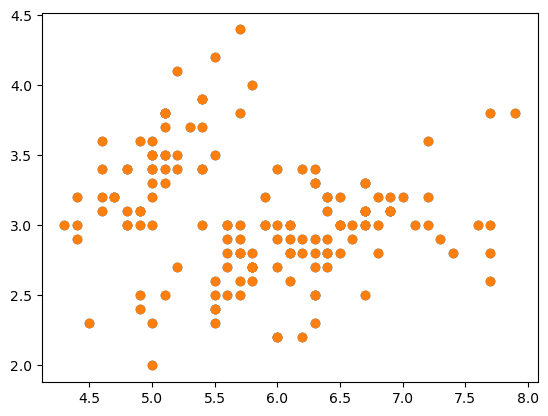

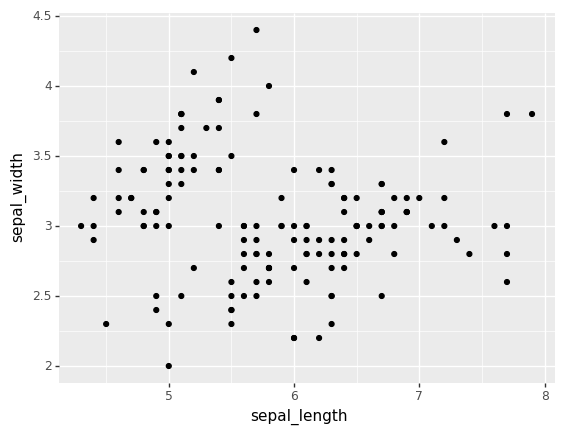

<ggplot: (8774480638534)>

In [20]:
import multiprocessing

import typing
class Irises(typing.List):

    @classmethod
    def from_dataframe(cls, df: pd.DataFrame):
        irises = cls()
        for ind, row in iris_df.iterrows():
            irises.append(IrisEntry.from_dataframe_row(row))
        return irises

    @classmethod
    def from_json(cls, iris_list: list):
        return cls([IrisEntry.from_json(irow) for irow in iris_list])
    
    def group_by_species(self) -> typing.Dict[Species, Irises]:
        groups = dict()
        for ir in self:
            groups.setdefault(ir.species, self.__class__())
            groups[ir.species].append(ir)
        return groups
    
    @property
    def plot(self):
        return PyPlotter(self)
    
    def ggplotter(self):
        return GGPlotter.from_irises(self)
    
    def calc_areas_parallel(self, n_processes: int = 4) -> typing.List[IrisArea]:
        with multiprocessing.Pool(n_processes) as p:
            areas = p.map(self.calc_iris_area, self)
        return areas
    
    @staticmethod
    def calc_iris_area(iris: IrisEntry) -> IrisArea:
        return iris.calc_area()


Irises.from_json(iris_list)[0]

irises = Irises.from_json(iris_list)
#irises.group_by_species()

import matplotlib.pyplot as plt

@dataclasses.dataclass
class PyPlotter:
    irises: Irises
    
    def sepal_scatter(self):
        plot = plt.scatter(
            x = [ir.sepal_length for ir in self.irises], 
            y = [ir.sepal_width for ir in self.irises], 
        )
        return plot
    
import plotnine
@dataclasses.dataclass
class GGPlotter:
    iris_df: pd.DataFrame
        
    @classmethod
    def from_irises(cls, irises: Irises):
        return cls(pd.DataFrame([dataclasses.asdict(ir) for ir in irises]))
    
    def sepal_scatter(self):
        return (plotnine.ggplot(plotnine.aes(x='sepal_length', y='sepal_width'), self.iris_df)
            + plotnine.geom_point()
        )
    
print(irises.calc_areas_parallel()[0])
plotter = PyPlotter(irises)
plotter.sepal_scatter()
len(irises)
irises.plot.sepal_scatter()
irises.ggplotter().sepal_scatter()

plotter = irises.ggplotter()
plotter.sepal_scatter()

150

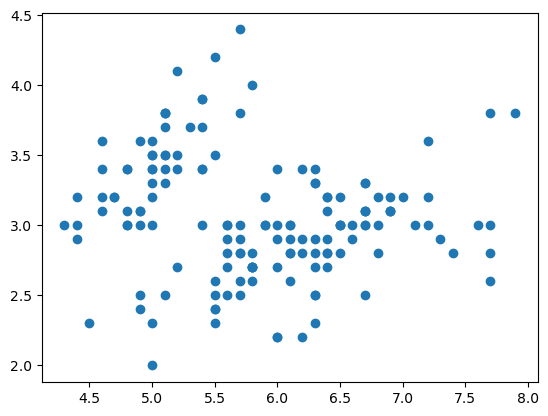

In [27]:
@dataclasses.dataclass
class IrisCollection:
    irises: typing.List[IrisEntry]
    
    @classmethod
    def from_json(cls, iris_list: list):
        return cls(irises=[IrisEntry.from_json(irow) for irow in iris_list])

iris_collection = IrisCollection.from_json(iris_list)

In [2]:
@attr.s(frozen=True, slots=True)
class IrisEntry:
    sepal_length: int = attrs.field(converter=float)
    sepal_width: int = attrs.field(converter=float)
    species: str = attrs.field(converter=str)
    
    @classmethod
    def from_dataframe_row(cls, row: pd.Series):
        return cls(
            sepal_length = row['sepal_length'],
            sepal_width = row['sepal_width'],
            species = row['species'],
        )
        
    def sepal_area(self) -> float:
        return SepalArea.from_entry(self)

Using the factory method you can create a list of entry objects that contain the data associated with each row.

In [25]:
entries = list()
for ind, row in iris_df.iterrows():
    new_iris = IrisEntry.from_dataframe_row(row)
    entries.append(new_iris)

entries[:3]

[IrisEntryDataclass(sepal_length=5.1, sepal_width=3.5, species='setosa'),
 IrisEntryDataclass(sepal_length=4.9, sepal_width=3.0, species='setosa'),
 IrisEntryDataclass(sepal_length=4.7, sepal_width=3.2, species='setosa')]

## Example 3: Validate Upstream

Ideally you could impose stricter validation rules on the data inserted into these objects. The `attrs` project maintains a superset of functionality from `dataclasses` (`attrs` actually predates and was an inspiration for `dataclasses`) and provides some convenient decorators and methods for type checking/conversions and value checking. Note below I create validation functions using the `@species.validator`, `@sepal_length.validator`, and `@sepal_width.validator`.

In [4]:
import attrs
import attr

@attr.s(frozen=True, slots=True)
class IrisEntryAttrs:
    '''Represents a single iris.'''
    sepal_length: int = attrs.field(converter=float)
    sepal_width: int = attrs.field(converter=float)
    species: str = attrs.field(converter=str) 
    
    ######################### Factory Methods #########################
    @classmethod
    def from_dataframe_row(cls, row: pd.Series):
        return cls(
            sepal_length = row['sepal_length'],
            sepal_width = row['sepal_width'],
            species = row['species'],
        )
    
    ######################### Validators #########################
    @species.validator
    def species_validator(self, attr, value) -> None:
        if not len(value) > 0:
            raise ValueError(f'{attr.name} cannot be empty')
    
    @sepal_length.validator
    @sepal_width.validator
    def meas_validator(self, attr, value) -> None:
        if not value > 0:
            raise ValueError(f'{attr.name} was out of range')
    
    ######################### Properties #########################
    def sepal_area(self) -> float:
        return self.sepal_length * self.sepal_width

## Example 3: Overloading Builtin Data Structures
Follwing conventions, one might be tempted to build a container object for the list of entries, although in some select cases it might make sense to create a container that directly inherits from the builtin `list`, or, as shown here `typing.List` (which is supposed to be more friendly for inheritence). In general inheritance is bad for your health, but in some select cases it can make things simpler. Here our primary use is to introduce the factory method `from_dataframe`, which simply calls the `IrisEntryAttrs` factory method to parse each row of the dataframe separately. This way you can add operations like grouping or filtering or even data type conversion as an extension of the list.

In [27]:
class IrisEntriesList(typing.List[IrisEntryDataclass]):
    
    ######################### Factory Methods #########################
    @classmethod
    def from_dataframe(cls, df: pd.DataFrame):
        # add type hint by hinting at returned variable
        elist = [IrisEntryDataclass.from_dataframe_row(row) for ind,row in df.iterrows()]
        new_entries: cls = cls(elist)
        return new_entries
        
    ######################### Grouping and Filtering #########################
    def group_by_species(self) -> typing.Dict[str, IrisEntriesList]:
        groups = dict()
        for e in self:
            groups.setdefault(e.species, self.__class__())
            groups[e.species].append(e)
        return groups

    def filter_sepal_area(self, sepal_area: float):
        elist = [e for e in self if e.sepal_area() >= sepal_area]
        entries: self.__class__ = self.__class__(elist)
        return entries
    
entries = IrisEntriesList.from_dataframe(iris_df)
entries[:2]

[IrisEntryDataclass(sepal_length=5.1, sepal_width=3.5, species='setosa'),
 IrisEntryDataclass(sepal_length=4.9, sepal_width=3.0, species='setosa')]

## Misc examples from the article
Here I'm including some of the quick examples I showed in the article.

### Don't Use Dataframes
Dataframes are generally popular because they are easy to use and great for plotting and creating summary statistics. While I often use them to work with tabular data, I suggest that you avoid using them as the primary data structures in your pipelines for two reasons: (1) you do not have explicit knowledge about your data without introspecting, and the introspection may need to happen at multiple levels of your program; and (2) they are often the wrong tools for the job (performance-wise) - even though they may be fine for many tasks.

In [15]:
iris_df['species']
iris_df.species

0         setosa
1         setosa
2         setosa
3         setosa
4         setosa
         ...    
145    virginica
146    virginica
147    virginica
148    virginica
149    virginica
Name: species, Length: 150, dtype: object

### Nested Iterables
For languages such as Python, one might prefer to use standard data structures like `list`s, `dict`s, and `set`s to structure your data because they are simple, and in many cases, the right tools for the job (as in, you can choose to use optimal data structures for whatever operations you will perform - an approach often missed by dataframe users). However, they can be a lot to keep track of as the data takes on more complicated structures and you are tracing it through larger and larger callstacks. You can see the complexity from the type hints I provide in `group_by_species` - a function that simply groups objects by species. The function accepts a list of dictionaries mapping strings to floats or strings, and it outputs a dictionary mapping strings to lists of dictionaries that map strings to floats or strings.

In [19]:
import json
import pprint
(json.dumps(iris_list[:5]))

'[{"sepal_length": 5.1, "sepal_width": 3.5, "species": "setosa"}, {"sepal_length": 4.9, "sepal_width": 3.0, "species": "setosa"}, {"sepal_length": 4.7, "sepal_width": 3.2, "species": "setosa"}, {"sepal_length": 4.6, "sepal_width": 3.1, "species": "setosa"}, {"sepal_length": 5.0, "sepal_width": 3.6, "species": "setosa"}]'

In [8]:
import statistics
statistics.mean([iris['petal_length'] for iris in irises])

3.758

In [9]:
EntryList = typing.List[typing.Dict[str, typing.Union[float, str]]]
def group_by_species(irises: EntryList) -> typing.Dict[str, EntryList]:
    groups = dict()
    for iris in irises:
        groups.setdefault(iris['species'], list())
        groups[iris['species']].append(iris)
    return groups

groups = group_by_species(irises)
groups.keys()

dict_keys(['setosa', 'versicolor', 'virginica'])